In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333: #and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:37<00:00, 280.54it/s]


10556

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10556, (174625,))

In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# standard = StandardScaler()
# adjusted_recordings = standard.fit_transform(adjusted_recordings)
#print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211445\AppData\Local\Temp\ipykernel_19368\660278963.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([6333, 1, 174625]), torch.Size([6333]))

In [24]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(1128,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')


############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  # Set the model to evaluation mode
    data = data.to(device)  # Move the data to the same device as the model
    with torch.no_grad():  # Turn off gradients to speed up this part
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  # Add batch dimension
            output = model(sample)
            predictions.append(output.item())
    return predictions


            
        

        


  2%|▏         | 1/50 [00:10<08:15, 10.11s/it]

Epoch [1/50], Loss: 5.9174
--------------------------------------------------


  4%|▍         | 2/50 [00:15<05:44,  7.18s/it]

Epoch [2/50], Loss: 1.1716
--------------------------------------------------
Epoch [3/50], Loss: 0.8440


  6%|▌         | 3/50 [00:21<05:24,  6.90s/it]

Mean Squared Error: 0.8672 and Mean Absolute Error: 0.7572
None
--------------------------------------------------
Epoch [4/50], Loss: 0.7774


  8%|▊         | 4/50 [00:27<05:02,  6.59s/it]

Mean Squared Error: 0.6780 and Mean Absolute Error: 0.6581
None
--------------------------------------------------
Epoch [5/50], Loss: 0.7550


 10%|█         | 5/50 [00:34<04:58,  6.64s/it]

Mean Squared Error: 0.7066 and Mean Absolute Error: 0.6675
None
--------------------------------------------------
Epoch [6/50], Loss: 0.6728


 12%|█▏        | 6/50 [00:41<04:48,  6.55s/it]

Mean Squared Error: 0.6624 and Mean Absolute Error: 0.6557
None
--------------------------------------------------
Epoch [7/50], Loss: 0.6812


 14%|█▍        | 7/50 [00:47<04:38,  6.48s/it]

Mean Squared Error: 0.6743 and Mean Absolute Error: 0.6667
None
--------------------------------------------------
Epoch [8/50], Loss: 0.6373


 16%|█▌        | 8/50 [00:53<04:30,  6.45s/it]

Mean Squared Error: 0.6069 and Mean Absolute Error: 0.6277
None
--------------------------------------------------
Epoch [9/50], Loss: 0.6312


 18%|█▊        | 9/50 [00:59<04:21,  6.38s/it]

Mean Squared Error: 0.6330 and Mean Absolute Error: 0.6343
None
--------------------------------------------------
Epoch [10/50], Loss: 0.6223


 20%|██        | 10/50 [01:05<04:07,  6.18s/it]

Mean Squared Error: 0.5945 and Mean Absolute Error: 0.6185
None
--------------------------------------------------
Epoch [11/50], Loss: 0.5914


 22%|██▏       | 11/50 [01:11<03:59,  6.13s/it]

Mean Squared Error: 0.6020 and Mean Absolute Error: 0.6269
None
--------------------------------------------------
Epoch [12/50], Loss: 0.5984


 24%|██▍       | 12/50 [01:18<04:05,  6.47s/it]

Mean Squared Error: 0.5922 and Mean Absolute Error: 0.6268
None
--------------------------------------------------
Epoch [13/50], Loss: 0.5802


 26%|██▌       | 13/50 [01:37<06:14, 10.12s/it]

Mean Squared Error: 0.5698 and Mean Absolute Error: 0.6125
None
--------------------------------------------------
Epoch [14/50], Loss: 0.5620


 28%|██▊       | 14/50 [01:46<05:48,  9.67s/it]

Mean Squared Error: 0.5693 and Mean Absolute Error: 0.6028
None
--------------------------------------------------
Epoch [15/50], Loss: 0.5765


 30%|███       | 15/50 [01:52<05:06,  8.75s/it]

Mean Squared Error: 0.5681 and Mean Absolute Error: 0.6022
None
--------------------------------------------------
Epoch [16/50], Loss: 0.5520


 32%|███▏      | 16/50 [01:59<04:32,  8.01s/it]

Mean Squared Error: 0.5570 and Mean Absolute Error: 0.6024
None
--------------------------------------------------
Epoch [17/50], Loss: 0.5508


 34%|███▍      | 17/50 [02:05<04:05,  7.45s/it]

Mean Squared Error: 0.5670 and Mean Absolute Error: 0.6059
None
--------------------------------------------------
Epoch [18/50], Loss: 0.5540


 36%|███▌      | 18/50 [02:11<03:46,  7.07s/it]

Mean Squared Error: 0.5568 and Mean Absolute Error: 0.6032
None
--------------------------------------------------
Epoch [19/50], Loss: 0.5411


 38%|███▊      | 19/50 [02:17<03:31,  6.83s/it]

Mean Squared Error: 0.5342 and Mean Absolute Error: 0.5902
None
--------------------------------------------------
Epoch [20/50], Loss: 0.5333


 40%|████      | 20/50 [02:23<03:17,  6.59s/it]

Mean Squared Error: 0.5394 and Mean Absolute Error: 0.5915
None
--------------------------------------------------
Epoch [21/50], Loss: 0.5371


 42%|████▏     | 21/50 [02:29<03:06,  6.43s/it]

Mean Squared Error: 0.5464 and Mean Absolute Error: 0.5929
None
--------------------------------------------------
Epoch [22/50], Loss: 0.5286


 44%|████▍     | 22/50 [02:35<02:58,  6.36s/it]

Mean Squared Error: 0.5298 and Mean Absolute Error: 0.5854
None
--------------------------------------------------
Epoch [23/50], Loss: 0.5219


 46%|████▌     | 23/50 [02:42<02:54,  6.45s/it]

Mean Squared Error: 0.5391 and Mean Absolute Error: 0.5896
None
--------------------------------------------------
Epoch [24/50], Loss: 0.5311


 48%|████▊     | 24/50 [02:48<02:44,  6.33s/it]

Mean Squared Error: 0.5434 and Mean Absolute Error: 0.5934
None
--------------------------------------------------
Epoch [25/50], Loss: 0.5202


 50%|█████     | 25/50 [02:55<02:38,  6.34s/it]

Mean Squared Error: 0.5119 and Mean Absolute Error: 0.5762
None
--------------------------------------------------
Epoch [26/50], Loss: 0.5097


 52%|█████▏    | 26/50 [03:01<02:31,  6.31s/it]

Mean Squared Error: 0.5211 and Mean Absolute Error: 0.5804
None
--------------------------------------------------
Epoch [27/50], Loss: 0.5197


 54%|█████▍    | 27/50 [03:07<02:23,  6.23s/it]

Mean Squared Error: 0.5328 and Mean Absolute Error: 0.5863
None
--------------------------------------------------
Epoch [28/50], Loss: 0.5148


 56%|█████▌    | 28/50 [03:12<02:13,  6.07s/it]

Mean Squared Error: 0.5006 and Mean Absolute Error: 0.5691
None
--------------------------------------------------
Epoch [29/50], Loss: 0.5004


 58%|█████▊    | 29/50 [03:18<02:04,  5.95s/it]

Mean Squared Error: 0.5245 and Mean Absolute Error: 0.5848
None
--------------------------------------------------
Epoch [30/50], Loss: 0.5125


 60%|██████    | 30/50 [03:24<01:56,  5.82s/it]

Mean Squared Error: 0.5340 and Mean Absolute Error: 0.5883
None
--------------------------------------------------
Epoch [31/50], Loss: 0.5097


 62%|██████▏   | 31/50 [03:29<01:49,  5.74s/it]

Mean Squared Error: 0.5110 and Mean Absolute Error: 0.5771
None
--------------------------------------------------
Epoch [32/50], Loss: 0.4913


 64%|██████▍   | 32/50 [03:35<01:41,  5.66s/it]

Mean Squared Error: 0.5039 and Mean Absolute Error: 0.5703
None
--------------------------------------------------
Epoch [33/50], Loss: 0.4994


 66%|██████▌   | 33/50 [03:40<01:36,  5.65s/it]

Mean Squared Error: 0.5177 and Mean Absolute Error: 0.5787
None
--------------------------------------------------
Epoch [34/50], Loss: 0.4991


 68%|██████▊   | 34/50 [03:46<01:29,  5.62s/it]

Mean Squared Error: 0.5086 and Mean Absolute Error: 0.5760
None
--------------------------------------------------
Epoch [35/50], Loss: 0.4875


 70%|███████   | 35/50 [03:51<01:24,  5.60s/it]

Mean Squared Error: 0.5021 and Mean Absolute Error: 0.5697
None
--------------------------------------------------
Epoch [36/50], Loss: 0.4958


 72%|███████▏  | 36/50 [03:57<01:18,  5.58s/it]

Mean Squared Error: 0.5183 and Mean Absolute Error: 0.5799
None
--------------------------------------------------
Epoch [37/50], Loss: 0.4952


 74%|███████▍  | 37/50 [04:03<01:12,  5.61s/it]

Mean Squared Error: 0.5091 and Mean Absolute Error: 0.5738
None
--------------------------------------------------
Epoch [38/50], Loss: 0.4835


 76%|███████▌  | 38/50 [04:08<01:07,  5.66s/it]

Mean Squared Error: 0.5001 and Mean Absolute Error: 0.5691
None
--------------------------------------------------
Epoch [39/50], Loss: 0.4918


 78%|███████▊  | 39/50 [04:14<01:01,  5.63s/it]

Mean Squared Error: 0.5124 and Mean Absolute Error: 0.5771
None
--------------------------------------------------
Epoch [40/50], Loss: 0.4884


 80%|████████  | 40/50 [04:20<00:56,  5.63s/it]

Mean Squared Error: 0.4980 and Mean Absolute Error: 0.5695
None
--------------------------------------------------
Epoch [41/50], Loss: 0.4697


 82%|████████▏ | 41/50 [04:25<00:50,  5.61s/it]

Mean Squared Error: 0.4946 and Mean Absolute Error: 0.5664
None
--------------------------------------------------
Epoch [42/50], Loss: 0.4818


 84%|████████▍ | 42/50 [04:31<00:44,  5.59s/it]

Mean Squared Error: 0.5138 and Mean Absolute Error: 0.5778
None
--------------------------------------------------
Epoch [43/50], Loss: 0.4870


 86%|████████▌ | 43/50 [04:36<00:39,  5.59s/it]

Mean Squared Error: 0.4990 and Mean Absolute Error: 0.5683
None
--------------------------------------------------
Epoch [44/50], Loss: 0.4736


 88%|████████▊ | 44/50 [04:42<00:33,  5.58s/it]

Mean Squared Error: 0.4842 and Mean Absolute Error: 0.5616
None
--------------------------------------------------
Epoch [45/50], Loss: 0.4751


 90%|█████████ | 45/50 [04:48<00:28,  5.61s/it]

Mean Squared Error: 0.5063 and Mean Absolute Error: 0.5726
None
--------------------------------------------------
Epoch [46/50], Loss: 0.4785


 92%|█████████▏| 46/50 [04:53<00:22,  5.58s/it]

Mean Squared Error: 0.5031 and Mean Absolute Error: 0.5722
None
--------------------------------------------------
Epoch [47/50], Loss: 0.4697


 94%|█████████▍| 47/50 [04:59<00:16,  5.57s/it]

Mean Squared Error: 0.4946 and Mean Absolute Error: 0.5655
None
--------------------------------------------------
Epoch [48/50], Loss: 0.4716


 96%|█████████▌| 48/50 [05:04<00:11,  5.58s/it]

Mean Squared Error: 0.5053 and Mean Absolute Error: 0.5716
None
--------------------------------------------------
Epoch [49/50], Loss: 0.4793


 98%|█████████▊| 49/50 [05:10<00:05,  5.64s/it]

Mean Squared Error: 0.5020 and Mean Absolute Error: 0.5708
None
--------------------------------------------------
Epoch [50/50], Loss: 0.4658


100%|██████████| 50/50 [05:16<00:00,  6.32s/it]

Mean Squared Error: 0.4880 and Mean Absolute Error: 0.5638
None
--------------------------------------------------


Mean Squared Error: 0.4568 and Mean Absolute Error: 0.5457


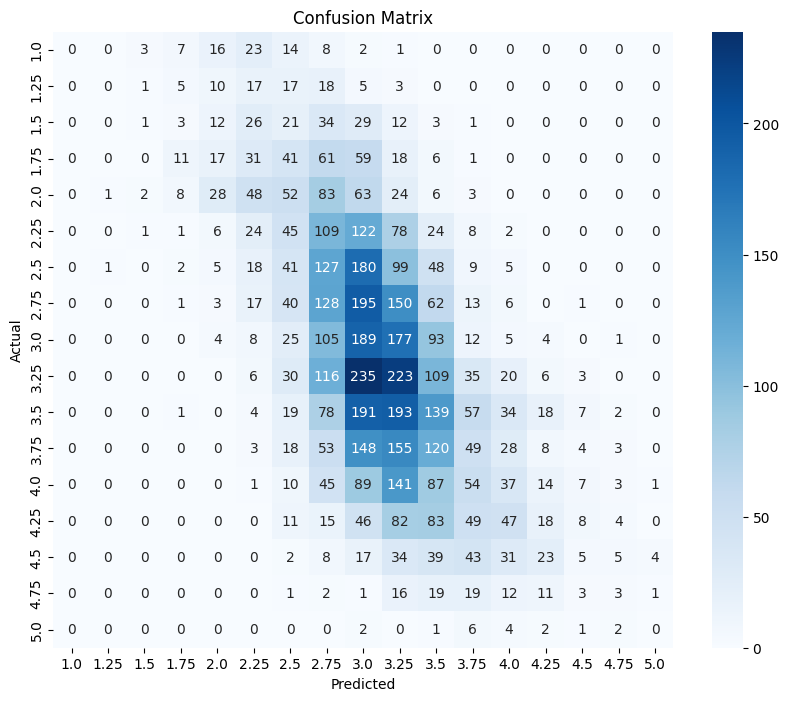

Accuracy: 0.1415
None


In [9]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

Mean Squared Error: 0.4984 and Mean Absolute Error: 0.5682


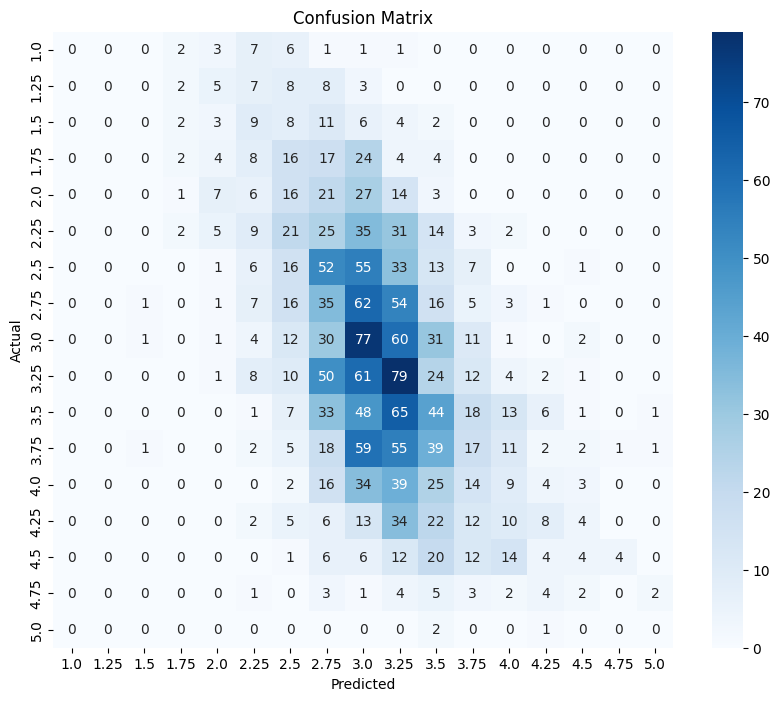

Accuracy: 0.1454


In [10]:
evaluate_model(modelCNN, test_loader,conf=True)

Mean Squared Error: 0.4574 and Mean Absolute Error: 0.5478


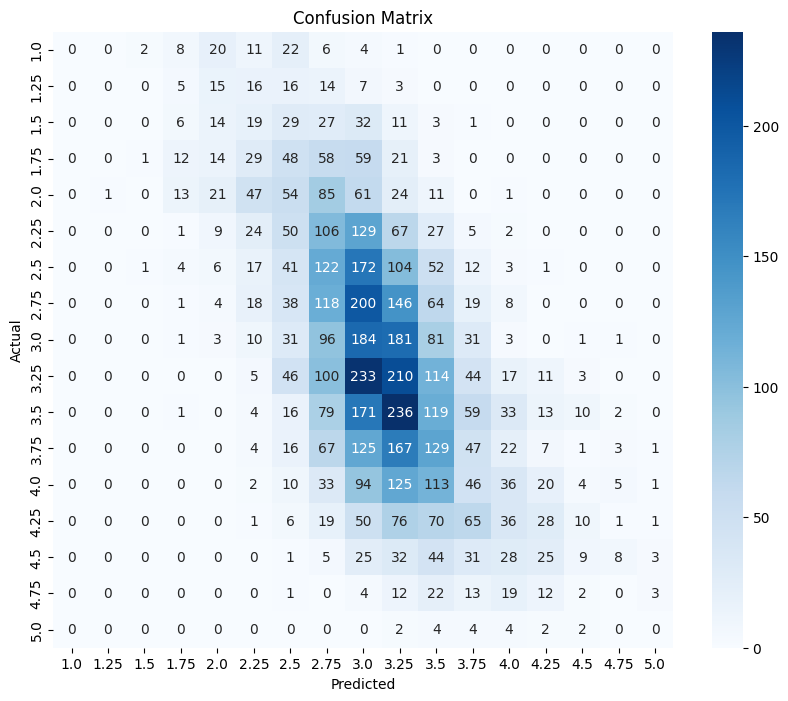

Accuracy: 0.1341


In [11]:
evaluate_model(modelCNN, train_loader,conf=True)

# Official Test Data

In [18]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/test'
test_label = {}
lenghts = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            test_label[filename] = data['audio_data']
            lenghts.append(len(data['audio_data']))
print(max(lenghts))
            

100%|██████████| 1863/1863 [00:04<00:00, 421.95it/s]

133534


In [19]:
for recording_test in test_label:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(test_label[recording_test], (max_length // len(test_label[recording_test]) + 1))[:max_length]
    test_label[recording_test] = repeated_recording
    
for i in test_label:
    print(i, test_label[i].shape)



10011.pkl (174625,)
10025.pkl (174625,)
10033.pkl (174625,)
10036.pkl (174625,)
10043.pkl (174625,)
10067.pkl (174625,)
10074.pkl (174625,)
10079.pkl (174625,)
10083.pkl (174625,)
10090.pkl (174625,)
10092.pkl (174625,)
10097.pkl (174625,)
10099.pkl (174625,)
10110.pkl (174625,)
10116.pkl (174625,)
10120.pkl (174625,)
10149.pkl (174625,)
10179.pkl (174625,)
10184.pkl (174625,)
10189.pkl (174625,)
10191.pkl (174625,)
10192.pkl (174625,)
10194.pkl (174625,)
10200.pkl (174625,)
10202.pkl (174625,)
10204.pkl (174625,)
10206.pkl (174625,)
10207.pkl (174625,)
10216.pkl (174625,)
10222.pkl (174625,)
10224.pkl (174625,)
10235.pkl (174625,)
10236.pkl (174625,)
10240.pkl (174625,)
10242.pkl (174625,)
10251.pkl (174625,)
10253.pkl (174625,)
10259.pkl (174625,)
10267.pkl (174625,)
10271.pkl (174625,)
10277.pkl (174625,)
10279.pkl (174625,)
10286.pkl (174625,)
10287.pkl (174625,)
10288.pkl (174625,)
10290.pkl (174625,)
10291.pkl (174625,)
10293.pkl (174625,)
10306.pkl (174625,)
10315.pkl (174625,)


In [29]:
FinalTestAudio = []
for i in test_label:
    FinalTestAudio.append(test_label[i])

FinalTestDataset = torch.tensor(FinalTestAudio, dtype=torch.float32).unsqueeze(1)

results = predict(modelCNN, FinalTestDataset, device)
print(len(results))


1863


In [33]:
import pandas as pd
labels_final = test_label.keys()
labels_final = list(labels_final)   
df = pd.DataFrame({'ID': labels_final, 'Label': results})
df.to_csv('results.csv', index=False)

In [32]:
df

,ID,Label
0,10011.pkl,3.361807
1,10025.pkl,2.402473
2,10033.pkl,3.675332
3,10036.pkl,3.145396
4,10043.pkl,3.845446
...,...,...
1858,22393.pkl,3.463685
1859,22394.pkl,3.382677
1860,22400.pkl,4.610821
1861,22401.pkl,2.168797
